# Project Goal

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. We will build a model for such a prediction.

The goal is for the RMSE metric on the test set to be 48 or less.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [13]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [14]:
pip install scikit-learn --upgrade

Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install lightgbm 

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import sklearn
import datetime
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import lightgbm as lgb

In [17]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
plt.rcParams['figure.facecolor'] = 'w'

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 30

### Load Data

In [18]:
data = pd.read_csv('taxi.csv')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [20]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


## Data Preprocessing

There are 26496  rows and 2 columns. We will convert the values in datetime to datetime format and assign them to the index to create a time series. There are no missing values.

In [21]:
# Reading the data and converting the date information to datetime format

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d %H:%M:%S')
data = pd.read_csv('taxi.csv',
                        index_col='datetime',
                        parse_dates=True,  
                        date_parser=dateparse)

In [22]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


We need to arrange the data in chronological order and look at the is_monotonic attribute of the table index to check it. If the order is chronological, the attribute will return True; if not, False.

In [23]:
# Sorting data, assigning labels, and checking that it is in chronological order

data.sort_index(inplace=True)
data.index.name = None
data.columns = ['num_orders']
data.index.is_monotonic

True

In [24]:
data.head()

,num_orders
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [25]:
# Checking dataframe

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data ranges from March 1, 2018 to August 31, 2018.

In [26]:
# Calculating descriptive statistics of the time series

data.describe()

,num_orders
count,26496.00
mean,14.07
std,9.21
min,0.00
25%,8.00
50%,13.00
75%,19.00
max,119.00


## Analysis

We need the time series data to be resampled by the hour so that we can predict the number of rides in the next hour. We also need the data to be stationary so that we can do forecasting. We will analyze the data and smooth out any trend or seasonality so that we result in data with a constant mean, constant variance, and an autocovariance that does not depend on time.

In [27]:
# Resampling the full data by the hour

data = data.resample('1H').sum()

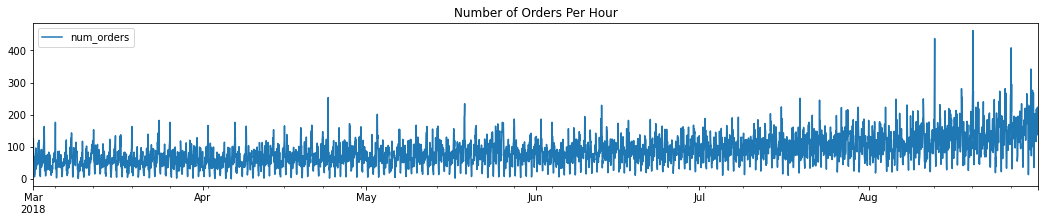

In [28]:
# Plot the average number of taxi rides per hour

data.plot()
plt.title("Number of Orders Per Hour")
plt.show()

There seems to be a positive trend with occasional spikes in numbers of orders.

Let's look at the data for August to get a closer look at the patterns.

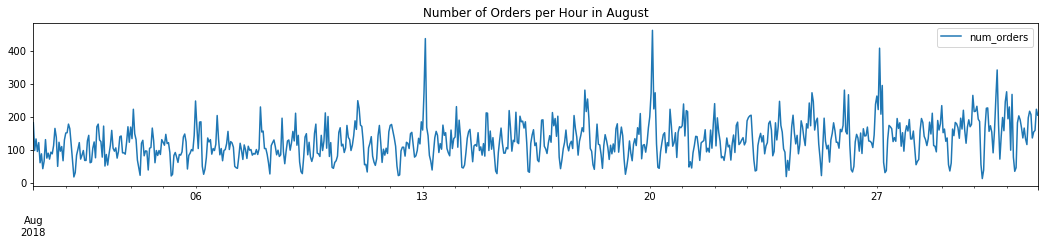

In [29]:
# Slicing out the data for August

data_aug = data['2018-08-1':'2018-08-31']
data_aug.plot()
plt.title("Number of Orders per Hour in August")
plt.show()

There seems to be a spike in orders in a certain hour every week. We will slice out the August data and resample the data per day to get a clearer visual of the data.

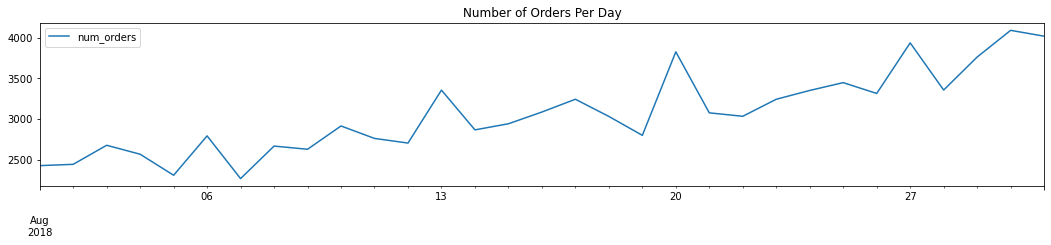

In [30]:
# Resampling August data by the day

data_aug_by_day = data['2018-08-1':'2018-08-31'].resample('D').sum()
data_aug_by_day.plot()
plt.title("Number of Orders Per Day")
plt.show()

There is a clear positive trend and seasonality. The number of orders trends upwards in August over the course of the month. There are high spikes weekly on August 6, 13, 20, and 27. This may be due to the day of the week. It is likely a weekend when taxis tend to be needed more. We will check this.

In [31]:
# Creating a column with the number of orders per hour per day of week
# The day of the week with Monday=0, Sunday=6.

data_aug_by_day['dayofweek'] = data_aug_by_day.index.dayofweek

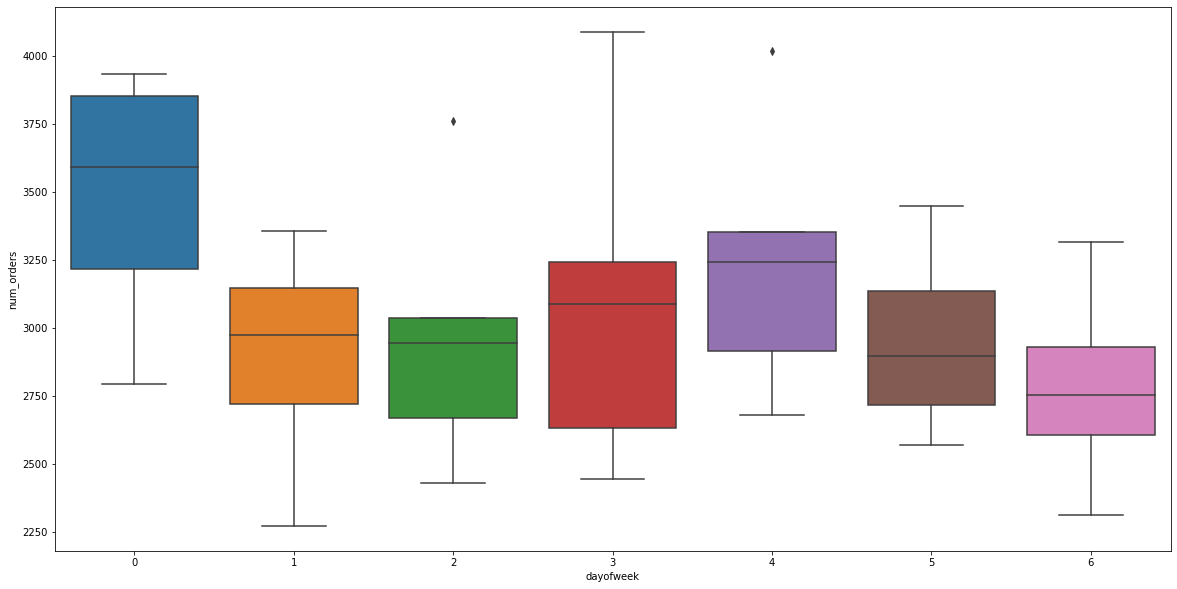

In [32]:
# Plotting the number of orders per day grouped by dayofweek

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x = data_aug_by_day['dayofweek'],
            y = data_aug_by_day['num_orders'],)
plt.show()

We can see from this boxpot that the highest median number of orders occurs on Monday, with Friday being the second most popular day for orders. Yet on Thursday there are outliers and the range of taxi orders can even be higher than for Monday. Based on this plot, we will create a dayofweek feature in the data.

We will create a function to check the rolling mean and rolling standard deviation of the data. The size of the rolling window depends on the sample size and periodicity of the data. We will use a short rolling window size (6) for the data since it is collected in short intervals.

In [33]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(6).mean()
    rolstd = timeseries.rolling(6).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

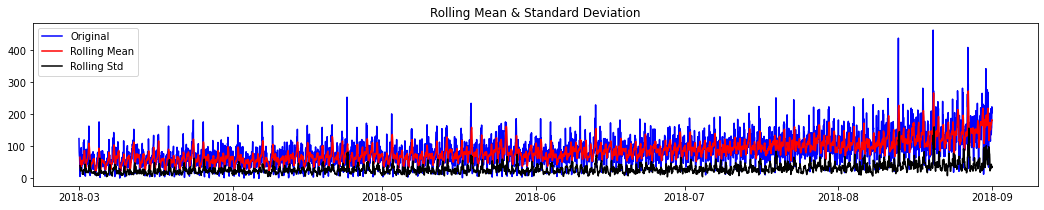

In [34]:
# Checking the statistics for data

test_stationarity(data)

We can see that the rolling mean is not a flat line. This can be due to a trend or seasonality. We will need to eliminate trend and seasonality before forecasting.

### Eliminating Trend and Seasonality

There are two methods to remove trend and seasonality:
- Differencing – taking the difference with a particular time lag
- Decomposition – modeling both trend and seasonality and removing them from the model.

In differencing we take the difference of the observation at a particular instant with that at the previous instant. This often works well in improving stationarity.

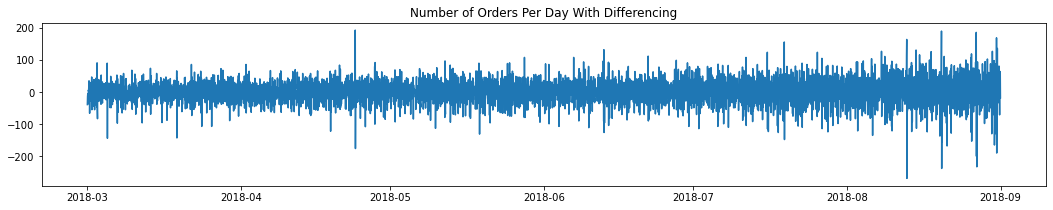

In [35]:
# Differencing data

differenced_data = data-data.shift()
plt.plot(differenced_data)
plt.title("Number of Orders Per Day With Differencing")
plt.show()

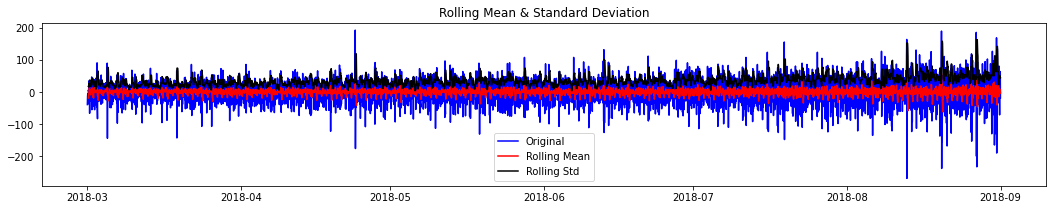

In [36]:
# Checking statistics of data with differencing

differenced_data.dropna(inplace=True)
test_stationarity(differenced_data)

We can see the rolling mean is a flat line now. Now we will use decomposition to eliminate trend and seasonality.

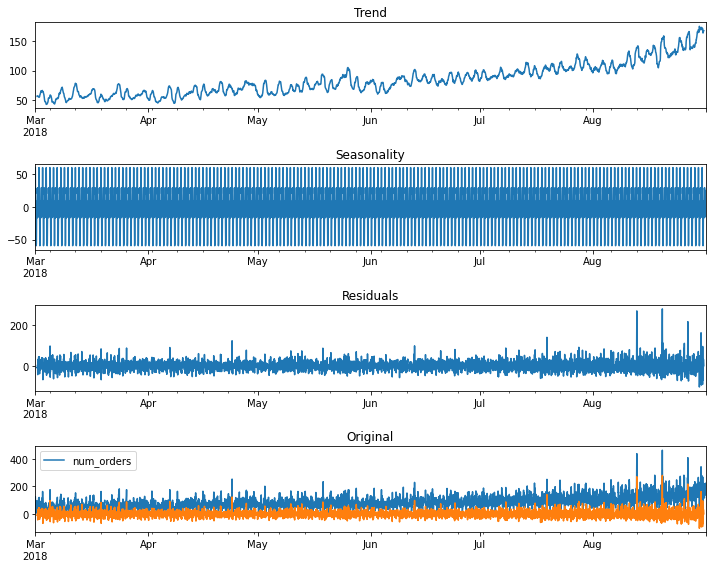

In [37]:
# Decomposition

decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 8))

#plt.subplot(411)
#plt.plot(ts_log, label='Original')

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(413)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.subplot(414)
data.plot(ax=plt.gca())
plt.title('Original')
decomposed.resid.plot(ax=plt.gca())
plt.tight_layout()

## Feature Engineering

We will engineer features to help our forecast including calendar features, lag features, and rolling_mean features to make our timeseries data stationary. The time of day and other time features should influence taxi orders so we will first create a function for cyclical encoding.

In [38]:
# Creating a function to encode cyclical features

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [39]:
# Creating a function to develop calendar, lag and rolling mean features

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data = encode(data, 'hour', 24)
    data['month'] = data.index.month
    data = encode(data, 'month', 12)
    data['day'] = data.index.day
    data = encode(data, 'day', 31)
    data['dayofweek'] = data.index.dayofweek
    data = encode(data, 'dayofweek', 7)
    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
    return data


In [40]:
# Creating features

data = make_features(data, 4, 4)

In [41]:
data.head(5)

,num_orders,hour,hour_sin,hour_cos,month,month_sin,month_cos,day,day_sin,day_cos,dayofweek,dayofweek_sin,dayofweek_cos,lag_1,lag_2,lag_3,lag_4,rolling_mean
2018-03-01 00:00:00,124,0,0.00,1.00,3,1.00,0.00,1,0.20,0.98,3,0.43,-0.90,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,0.26,0.97,3,1.00,0.00,1,0.20,0.98,3,0.43,-0.90,124.00,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,0.50,0.87,3,1.00,0.00,1,0.20,0.98,3,0.43,-0.90,85.00,124.00,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,0.71,0.71,3,1.00,0.00,1,0.20,0.98,3,0.43,-0.90,71.00,85.00,124.00,NaN,NaN
2018-03-01 04:00:00,43,4,0.87,0.50,3,1.00,0.00,1,0.20,0.98,3,0.43,-0.90,66.00,71.00,85.00,124.00,86.50


Since the value in the dates in not ordinal, meaning there is no ranking significance to the number value, we will use get dummies to create dummy variables to help our machine learning. It seems based on the seasonality in the visualizations that day of the week is of particular significance for this data, so we will use get dummies for day of the week.

In [42]:
data = pd.get_dummies(data, columns = ["dayofweek"])

In [43]:
data.head()

,num_orders,hour,hour_sin,hour_cos,month,month_sin,month_cos,day,day_sin,day_cos,...,lag_3,lag_4,rolling_mean,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
2018-03-01 00:00:00,124,0,0.00,1.00,3,1.00,0.00,1,0.20,0.98,...,NaN,NaN,NaN,0,0,0,1,0,0,0
2018-03-01 01:00:00,85,1,0.26,0.97,3,1.00,0.00,1,0.20,0.98,...,NaN,NaN,NaN,0,0,0,1,0,0,0
2018-03-01 02:00:00,71,2,0.50,0.87,3,1.00,0.00,1,0.20,0.98,...,NaN,NaN,NaN,0,0,0,1,0,0,0
2018-03-01 03:00:00,66,3,0.71,0.71,3,1.00,0.00,1,0.20,0.98,...,124.00,NaN,NaN,0,0,0,1,0,0,0
2018-03-01 04:00:00,43,4,0.87,0.50,3,1.00,0.00,1,0.20,0.98,...,85.00,124.00,86.50,0,0,0,1,0,0,0


## Training

We will train different models with various hyperparameters. First we prepare the data for model training by assigning the features and target. We will then split the data into a 3 sets for training (80%), validation (10%) and testing (10%) the final model. We will create a function using the RMSE metric to evaluate the models. We will then create a dummy model for a sanity check. We will then build several models using a linear regression, random forest regression, and LightGBM with hyperparameter tuning. We will analyze the quality of the models using the RMSE metric and select the best model to use for our test data.

In [44]:
# Splitting the data using indexing twice to create a 8:1:1 split for training, validation, and testing.
# We will use valid set for model training and test set for the final model

train, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train, shuffle=False, test_size=0.111)
train = train.dropna()
valid = valid.dropna()
test = test.dropna()

# Checking size of each set of data
print("train: ",train.size)
print("valid: ",valid.size)
print("test: ",test.size)

train:  84672
valid:  10608
test:  10608


In [45]:
# Assigning features and target

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [46]:
# Creating a function to calculate RMSE

def rmse(y_valid, y_pred):
    rmse = mean_squared_error(y_valid, y_pred)**0.5
    print("The rmse is:", rmse)

### Baselines for Models

We will use a Dummy Regressor to create a baseline model. We will also create a baseline predictor for our time series without training:
 - First, we will predict all values of the test sample with the median.
 - Secondly, we will predict the new value x(t) by the previous value in the series, defined as x(t-1). This method is metric-independent. Note that the latest value of the train data can be used as the first value of the test data. 

In [47]:
# Creating as a baseline with DummyRegressor

# create a dummy regressor
dummy_reg = DummyRegressor(strategy='mean')
# fit it on the training set
dummy_reg.fit(features_train, target_train)
# make predictions on the test set
target_pred = dummy_reg.predict(features_valid)

# calculate root mean squared error
rmse(target_valid, target_pred)

The rmse is: 58.242682413133586


In [48]:
# Creating a baseline using the median for number of orders in the valid set

print('Median number of rides per hour in valid set:', valid['num_orders'].median())

pred_median = np.ones(target_valid.shape) * train['num_orders'].median()

# calculate root mean squared error
rmse(target_valid, pred_median)

Median number of rides per hour in valid set: 105.0
The rmse is: 59.68095795210938


In [49]:
# Creating a basic model using the previous value in the series x(t-1)

pred_previous = valid.shift() #getting the value from the previous position for the current index position
pred_previous.iloc[0] = train.iloc[-1] #filling the first value in the test set with the last value of the train set
rmse(valid['num_orders'], pred_previous['num_orders']) # comparing the test set with the values of the previous values test set. As a baseline model

The rmse is: 47.246345832986236


### Linear Regression

In [50]:
# Training a Linear Regression model

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
target_pred = lr_model.predict(features_valid)

# calculate root mean squared error
rmse(target_valid, target_pred)

The rmse is: 37.31258012579145


### Random Forest Regression

In [51]:
# Developing a model with RandomForestRegressor. Using best score of basic model of previous value
 
best_score = 50
best_est = 0
for est in range(1, 5):
    RFR_model = RandomForestRegressor(n_estimators= est) 
    RFR_model.fit(features_train, target_train)
    target_pred = RFR_model.predict(features_valid)
    score = mean_squared_error(target_valid, target_pred)**0.5
    if score < best_score:
        best_score = score # save best score on validation set
        best_est = est # save number of estimators corresponding to best score
        
print("RMSE of the best model on the validation set (n_estimators = {}): {}".format(best_est, best_score))

RMSE of the best model on the validation set (n_estimators = 4): 37.19402890517637


### LightGBMRegressor
LightGBMRegressor is a gradient boosting framework that uses tree based learning algorithms.

In [52]:
lgb_model = lgb.LGBMRegressor(
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 500,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =7,
    min_data_in_leaf=20,
    bagging_fraction = 1.0,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6)


lgb_model = lgb_model.fit(features_train, target_train)

target_pred = lgb_model.predict(features_valid)
rmse(target_valid, target_pred)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
The rmse is: 33.97544387695031


## Testing

The Light GBM had the best RMSE, so we will use that with our test set.

We will refit the final model on the combined train+validation set before evaluating it on the test set since we have a time series with a growing trend.

In [53]:
# Splitting the data using indexing twice to create a 9:1 split for training and testing
# Essentially combining the earlier train and validation sets in chronological order to create a train set for the model

train_final, test = train_test_split(data, shuffle=False, test_size=0.1)
train_final = train_final.dropna()
test = test.dropna()

# Checking size of each set of data
print("train_final: ",train_final.size)
print("test: ",test.size)

train_final:  95280
test:  10608


In [54]:
# Assigning features and target

features_train_final = train_final.drop(['num_orders'], axis=1)
target_train_final = train_final['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [55]:
lgb_model = lgb.LGBMRegressor(
    task = 'predict',
    application = 'regression',
    objective = 'root_mean_squared_error',
    boosting_type="gbdt",
    num_iterations = 500,
    learning_rate = 0.05,
    num_leaves=15,
    tree_learner='feature',
    max_depth =7,
    min_data_in_leaf=7,
    bagging_fraction = 1,
    bagging_freq = 100,
    reg_sqrt='True',
    metric ='rmse',
    feature_fraction = 0.6)


lgb_model2 = lgb_model.fit(features_train_final, target_train_final)

target_pred = lgb_model.predict(features_test)
rmse(target_test, target_pred)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_freq is set=100, subsample_freq=0 will be ignored. Current value: bagging_freq=100
The rmse is: 42.342227650045956


## General Conclusion
 
The data contained 26496 entries of datetime data in ten minute intervals ranging from March 1, 2018 to August 31, 2018. In order to predict the number of taxi rides for the next hour, we resampled the data in units of an hour. Plot indicated a positive trend and seasonality in the data.
 
To examine this more closely, we took a slice of data for August resampled by dayofweek. A boxplot of number of orders per dayofweek in August showed that the highest median number of orders occurs on Monday, with Friday being the second most popular day for orders. Yet on Thursday there are outliers and the range of taxi orders can even be higher than for Monday. Based on this plot, we created a dayofweek feature in the data and created dummy variables for each day so that the model would not see the values in dayofweek as ordinal. We engineered features to help our forecast including calendar features, lag features, and rolling_mean features. We used cyclical encoding for calendar features. 
We prepared the data for model training by split the data into a 3 sets for training (80%), validation (10%) and testing (10%) and assigned the validation and testing as the later chronological data. We used the RMSE metric to evaluate the models. We used Dummy Regressor for a sanity check., as well as a control model using the median of the train values, and a basic model using the previous value in the series.  We will then built several models using a linear regression, random forest regression, and LightGBM with hyperparameter tuning. 
We evaluated the RMSE scores for the models and chose the LightGBM model to predict values in the test set since it had the best RMSE score.
 
Dummy Regressor: 58.2
Median Control: 59.7
Previous Value: 47.2
Linear Regression: 37.3
Random Forest Regression: 35.4
LightGBM: 33.8
 
 
LightGBM on the test data: 42.3
 
The LightGBM was the best model of the models we tried at predicting the number of taxi orders in the next hour. It looks like the model had some overfitting but the result is a slight improvement over the basic model of previous value.